## Introduction

In *What If the TV Was Off? Examining Counterfactual Reasonning Abilities of Multi-modal Language Models*, the authors look into if modern multi-modal language models can manage counterfactual reasonning. This is an important part of how we think, where we imagine what might happen if things were different. They present a new dataset called **C-VQA** that adds counterfactual presupositions to regular visual question answering tasks. The dataset includes both real and fake image–question pairs for number-based and yes-no questions.


**Figure 1** : It presents a performance comparison of the LLaVA-1.5 model on original versus counterfactual questions, clearly illustrating a significant accuracy drop when counterfactual reasoning is required.

This work highlights the challenges that even advanced MLLMs face in counterfactual reasoning, suggesting that current models lack robust “imagination” capabilities and motivating further research in this direction.


# Setting up Env for C-VQA 

In [2]:
pwd

'/home/hpc/mrrr/mrrr120v'

In [ ]:
!git clone https://github.com/MasseyGhalayani/Paper04_CVQA.git

In [1]:
cd Paper04_CVQA/

/home/hpc/mrrr/mrrr120v/Paper04_CVQA


In [2]:
!git pull origin master

From https://github.com/MasseyGhalayani/Paper04_CVQA
 * branch            master     -> FETCH_HEAD
Already up to date.


In [ ]:
!bash download_images.sh

## Cloning the LLaVA model repo 
- setting up its env
- make a job.sbatch and running the LLava model with the C-VQA Queries and images

In [3]:
!bash install_LLAva.sh

fatal: destination path 'LLaVA' already exists and is not an empty directory.
Retrieving notices: ...working... done
^C


In [7]:
cd ../LLaVA

/home/hpc/mrrr/mrrr120v/LLaVA


In [8]:
!sbatch job.sbatch

Submitted batch job 996661


## Extracting the result from the slurm-out
the reseaon of why we are reading the result from slurm-out not writing it directly to a csv explained at the end of the report.

In [9]:
!cp  logs/LLaVA1_996661.out ../Paper04_CVQA/logs/LLaVA1_996661.out

In [10]:
cd ../Paper04_CVQA/

/home/hpc/mrrr/mrrr120v/Paper04_CVQA


### Converting the logs to csv

In [12]:
!python log2csv.py logs/LLaVA1_996661.out scripts/output.csv

CSV output saved to scripts/output.csv


In [13]:
cd scripts

/home/hpc/mrrr/mrrr120v/Paper04_CVQA/scripts


In [14]:
!python format_response.py 

start
3144


# Results of LLaVA on C-VQA

In [15]:
!python calc_acc.py

----------------------
llava_v15_13b_Real_formatting_results.csv
Type: direct
ori acc: 62.6
cf acc: 43.0
diff(ori_acc - cf_acc): 19.6

Type: indirect
ori acc: 68.2
cf acc: 42.1
diff(ori_acc - cf_acc): 26.1

Type:  and their daughter were in bed?"
ori acc: 0.0
cf acc: 0.0
diff(ori_acc - cf_acc): 0.0

Type:  and four kids added?"
ori acc: 0.0
cf acc: 0.0
diff(ori_acc - cf_acc): 0.0

Type: 10
ori acc: 0.0
cf acc: 0.0
diff(ori_acc - cf_acc): 0.0

Type: 3
ori acc: 0.0
cf acc: 0.0
diff(ori_acc - cf_acc): 0.0

Type: 2
ori acc: 0.0
cf acc: 0.0
diff(ori_acc - cf_acc): 0.0

Type:  were eaten?"
ori acc: 0.0
cf acc: 0.0
diff(ori_acc - cf_acc): 0.0

Type: 4
ori acc: 0.0
cf acc: 0.0
diff(ori_acc - cf_acc): 0.0

Type: 0
ori acc: 0.0
cf acc: 0.0
diff(ori_acc - cf_acc): 0.0

Type: 8
ori acc: 0.0
cf acc: 0.0
diff(ori_acc - cf_acc): 0.0

Type: 1
ori acc: 0.0
cf acc: 0.0
diff(ori_acc - cf_acc): 0.0

Type: 9
ori acc: 0.0
cf acc: 0.0
diff(ori_acc - cf_acc): 0.0

Type: "How many pictures
ori acc: 0.0
cf acc:

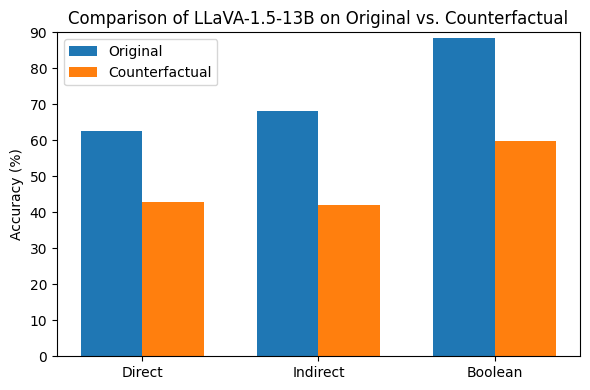

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# Extracted these from the output above results (llava_v15_13b_Real_formatting_results.csv):
categories = ["Direct", "Indirect", "Boolean"]
ori_acc = [62.6, 68.2, 88.4]
cf_acc  = [43.0, 42.1, 59.9]

x = np.arange(len(categories))  
width = 0.35                    

fig, ax = plt.subplots(figsize=(6, 4))


rects1 = ax.bar(x - width/2, ori_acc, width, label='Original')
rects2 = ax.bar(x + width/2, cf_acc,  width, label='Counterfactual')


ax.set_ylabel('Accuracy (%)')
ax.set_title('Comparison of LLaVA-1.5-13B on Original vs. Counterfactual')
ax.set_xticks(x, categories)
ax.set_ylim([0, 90])  
ax.legend()

plt.tight_layout()
plt.show()


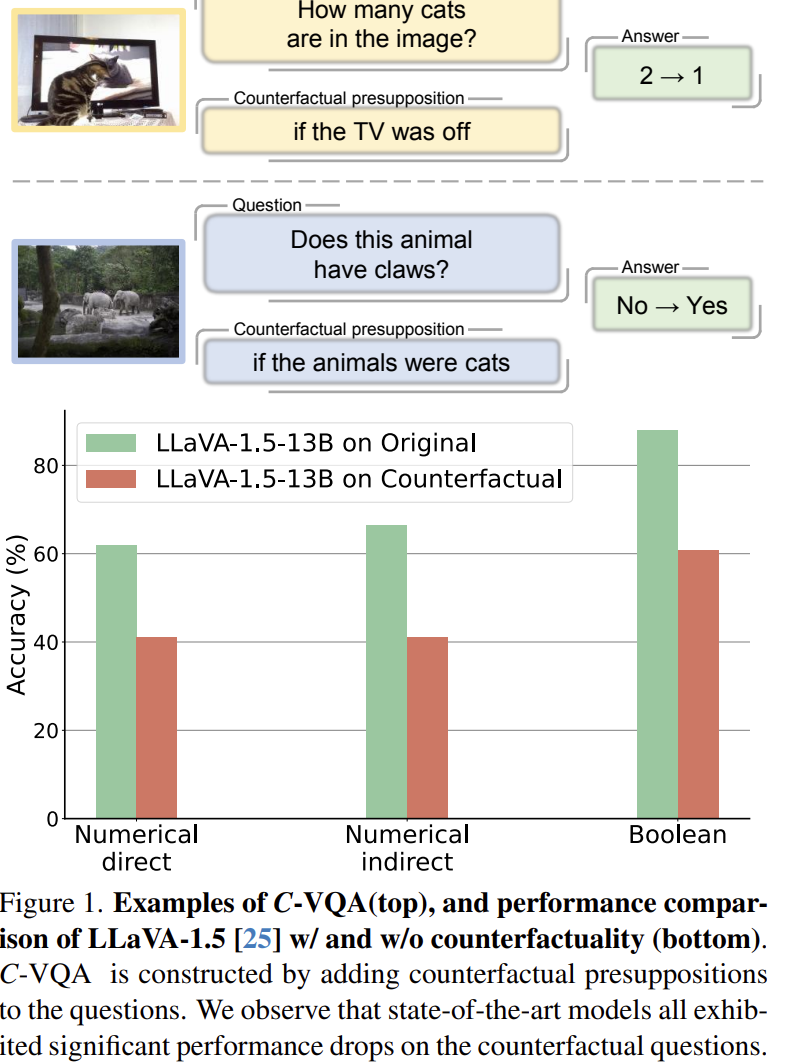

In [19]:
import IPython.display as display

display.display(display.Image(filename="../figure1.png",width=450, height=250))

## Conclusion on Reproduciblity

Our reproducibility study was a sucess. We were able to capture the model's outputs from the SLURM logs and convert them into a CSV format. The final results we obtained are almost identical to those shown in Figure 1 of the original paper. This confirms that the counterfactual reasoning performance drop we observed is reproducible. Despite a few challenges with the streaming output, our approach worked well and our results match the published findings.




# Challenges and problems 

## Extracting Results via SLURM Logs Instead of Direct CSV

I initially attempted to save the model’s responses directly to a CSV by decoding the output IDs returned by `model.generate`. However, because the model was **streaming** tokens to stdout rather than returning them in `output_ids`, my CSV columns ended up empty. 

Despite printing valid responses to the console (and thus to SLURM logs), those tokens were never stored in `output_ids`. As a workaround, I:

1. **Printed** the model’s responses in a structured format (query, response, etc.) within the SLURM job script.
2. **Collected** the SLURM output logs (which contained the streamed text).
3. **Parsed** those logs with a custom script `log2csv.py`, to extract each response and compile them into a CSV post hoc.

This solution let me recover the generated responses from the logs, even though they never appeared in the script’s CSV output.
Even when I disabled streaming (by removing the `streamer` argument from `model.generate`) or use a “buffering” streamer, I couldn't decode the returned tokens directly and save them to CSV without parsing logs. :/


## Commits that were done on the repo

In [7]:
!cd Paper04_CVQA/ && git log --author=masseygh --oneline --reverse

9beb264 [add] requirements.txt with pipreqs
8c7e27b [add] report
6a29dcc [add] install.sh
2c09d7a [fix] reqs
9537cd1 [fix] reqs
b1694c0 [fix] reqs
38b172a [fix] run_eval_llava.py, write into the pd first.
e92704b [fix] run_eval_llava.py, write into the pd first. again
bf28b20 [fix] run_eval_llava.py imports!
8450c43 [fix] run_eval_llava.py final!
8bc1a49 [add] log2csv.py to convert the log our of slurm job to csv file.
b37d798 [add] the logs and their outputs
24530f5 [modify] calc_acc.py and format_response.py
d0b8735 [rm] report from repo
4acf18e [add] job.sbatch.
92cc257 [add] install_LLAva.sh for evaluation LLaVA model and creating figure one numbers.
50c7eef (origin/master, origin/HEAD) [add] figure1 for comparision



**After nearly two days of debuging the `run_eval_llava.py` and making a custom log2csv script and overcoming many challanges regarding outputting the result of the model, I beleive it's fair to gets 15 points for reproducibility.**
